In [6]:
import common_functions
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
import glob
import time
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC
%matplotlib inline

In [3]:
# Load the classifier and parameters
data_file = 'classifier_model.p'
with open(data_file, mode='rb') as f:
    data = pickle.load(f)
    
svc = data['svc'] 
X_scaler = data['X_scaler']
colorspace = data['colorspace']
spatial = data['spatial']
histbin = data['histbin']
orient = data['orient']
pix_per_cell = data['pix_per_cell']
cell_per_block = data ['cell_per_block']
hog_channel = data['hog_channel']
spatial_feat = data ['spatial_feat']
hist_feat = data['hist_feat']
hog_feat = data['hog_feat']

In [4]:
test_pro_imgs = glob.glob('./cache/*.png')
test_pro_features = []
for test_pro_image in test_pro_imgs:
    image = mpimg.imread(test_pro_image)
    test_pro_features.append(
        common_functions.combine_img_features(
            image, color_space=colorspace, spatial_size=(spatial, spatial), hist_bins=histbin, orient=orient, 
            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, 
            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat
        )
    )

result_feat = X_scaler.transform(test_pro_features)

print('My SVC predicts: ', svc.predict(result_feat))

My SVC predicts:  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [22]:
test_pro_imgs = glob.glob('./cache/*.png')
test_pro_features = []
for test_pro_image in test_pro_imgs:
    image = mpimg.imread(test_pro_image)
    single_feature = common_functions.combine_img_features(
        image, color_space=colorspace, spatial_size=(spatial, spatial), hist_bins=histbin, orient=orient,
        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat
    )
    test_pro_features.append(single_feature)
    result_feat = X_scaler.transform(np.array(single_feature).reshape(1, -1))
    prediction = svc.predict(result_feat)
    print(test_pro_image, ', predicts: ', svc.predict(result_feat))

result_feat = X_scaler.transform(test_pro_features)

print('My SVC predicts: ', svc.predict(result_feat))

./cache/image-1.png , predicts:  [ 0.]
./cache/image-10.png , predicts:  [ 0.]
./cache/image-100.png , predicts:  [ 0.]
./cache/image-11.png , predicts:  [ 0.]
./cache/image-12.png , predicts:  [ 0.]
./cache/image-13.png , predicts:  [ 0.]
./cache/image-14.png , predicts:  [ 0.]
./cache/image-15.png , predicts:  [ 0.]
./cache/image-16.png , predicts:  [ 0.]
./cache/image-17.png , predicts:  [ 0.]
./cache/image-18.png , predicts:  [ 0.]
./cache/image-19.png , predicts:  [ 0.]
./cache/image-2.png , predicts:  [ 0.]
./cache/image-20.png , predicts:  [ 0.]
./cache/image-21.png , predicts:  [ 0.]
./cache/image-22.png , predicts:  [ 0.]
./cache/image-23.png , predicts:  [ 0.]
./cache/image-24.png , predicts:  [ 0.]
./cache/image-25.png , predicts:  [ 0.]
./cache/image-26.png , predicts:  [ 0.]
./cache/image-27.png , predicts:  [ 0.]
./cache/image-28.png , predicts:  [ 0.]
./cache/image-29.png , predicts:  [ 0.]
./cache/image-3.png , predicts:  [ 0.]
./cache/image-30.png , predicts:  [ 0.]
./

In [24]:
image = mpimg.imread('./cache/image-40.png')
single_feature = common_functions.combine_img_features(
    image, color_space=colorspace, spatial_size=(spatial, spatial), hist_bins=histbin, orient=orient,
    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
    spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat
)

result_feat = X_scaler.transform(np.array(single_feature).reshape(1, -1))

print('My SVC predicts: ', svc.predict(result_feat) == 1)

My SVC predicts:  [ True]


(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64,

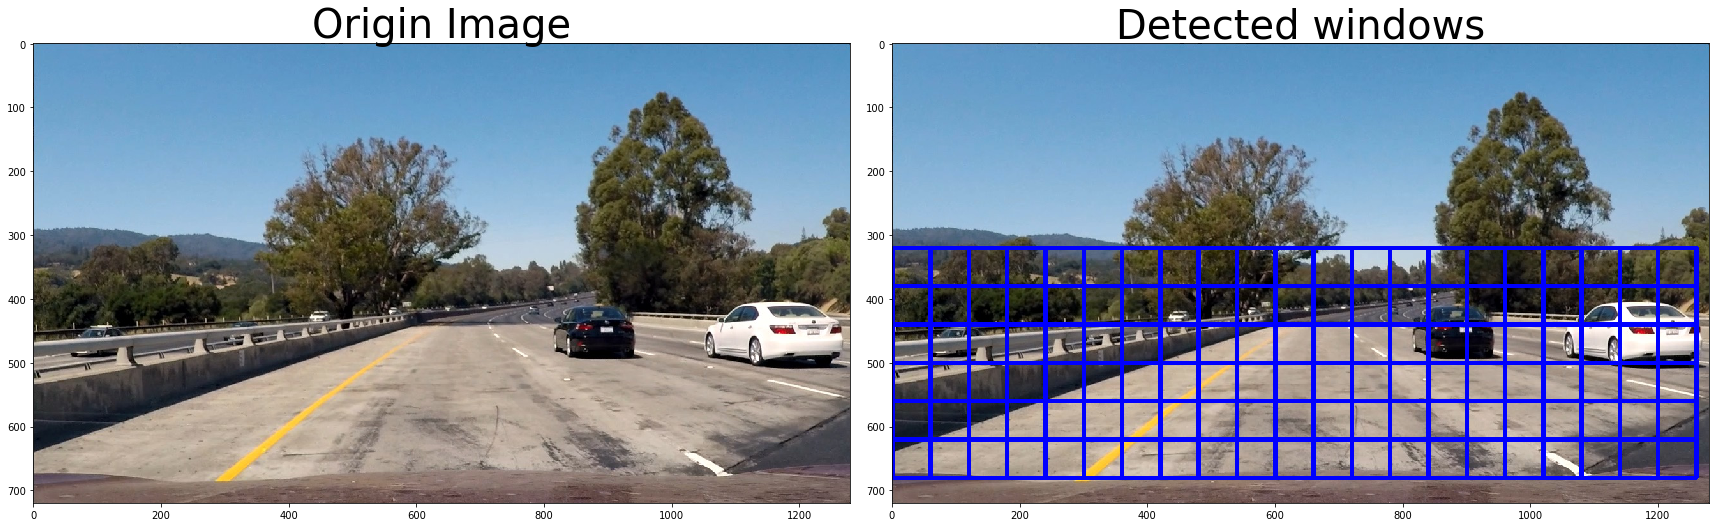

In [25]:
image = mpimg.imread('./test_images/test1.jpg')
draw_image = np.copy(image)

t=time.time()
windows = common_functions.slide_window(
    image, x_start_stop=[None, None], y_start_stop=[320, 720],
    xy_window=(120, 120), xy_overlap=(0.5, 0.5)
)

cut_images = []
detected_windows = []
num = 1
for window in windows:
    test_img = cv2.resize(image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
    #plt.imsave('./cache/image-' + str(num) + '.png', test_img)
    #num += 1
    print(test_img.shape)
    cut_images.append(test_img)
    features = common_functions.combine_img_features(
        test_img, color_space=colorspace, spatial_size=(spatial, spatial), hist_bins=histbin,
        orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat
    )
    
    test_features = X_scaler.transform(np.array(features).reshape(1, -1))
    
    prediction = svc.predict(test_features)
    
    if prediction == 1:
        detected_windows.append(window)

#detected_windows =  common_functions.search_windows(
#    image, windows, clf=svc, scaler=X_scaler, color_space=colorspace,
#    spatial_size=(spatial, spatial), hist_bins=histbin, orient=orient,
#    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
#    spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat
#)
t2 = time.time()
print(round(t2-t, 5), ' Seconds to search windows ...')

window_img = common_functions.draw_boxes(draw_image, detected_windows, color=(0, 0, 255), thick=6)                    

plt.figure()
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Origin Image', fontsize=40)

ax2.imshow(window_img)
ax2.set_title('Detected windows', fontsize=40)

plt.show()

In [27]:
for cut_img in cut_images:
    single_feature = common_functions.combine_img_features(
        cut_img, color_space=colorspace, spatial_size=(spatial, spatial), hist_bins=histbin, orient=orient,
        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat
    )
    result_feat = X_scaler.transform(np.array(single_feature).reshape(1, -1))
    prediction = svc.predict(result_feat)
    print(' predicts: ', svc.predict(result_feat))

 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:  [ 1.]
 predicts:

0.36107  Seconds to search windows ...


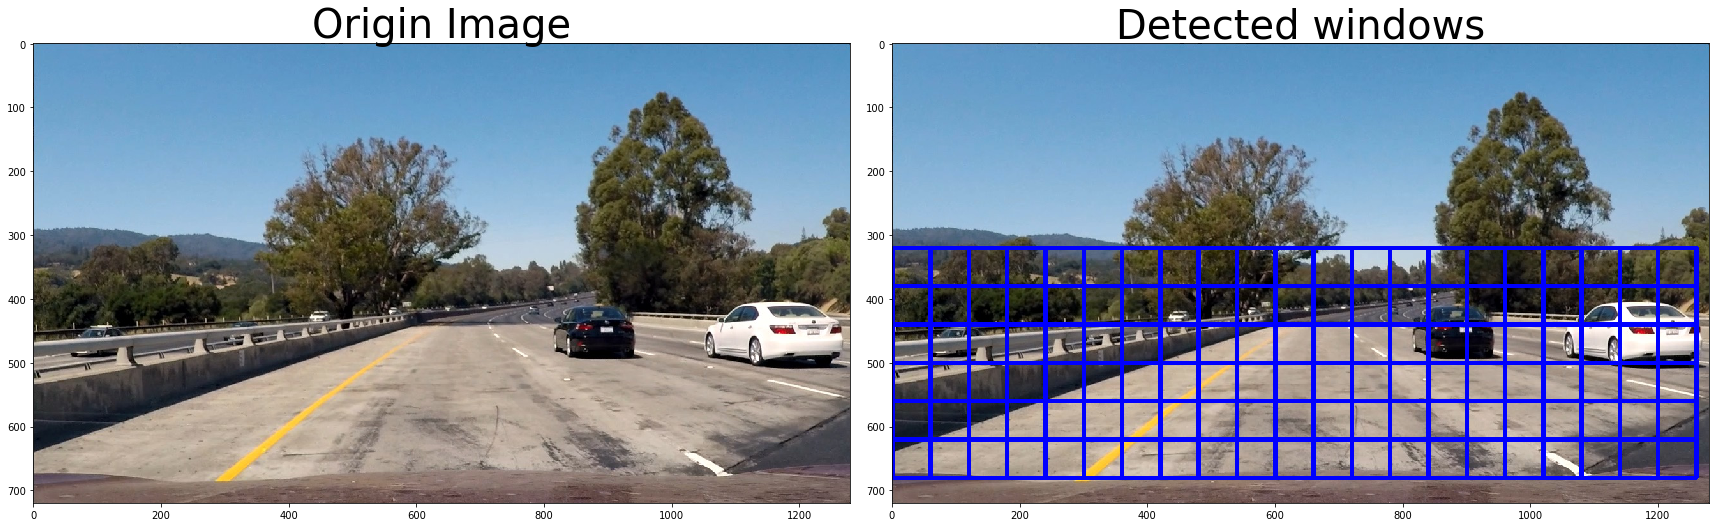

In [7]:
image = mpimg.imread('./test_images/test1.jpg')
draw_image = np.copy(image)

t=time.time()
windows = common_functions.slide_window(
    image, x_start_stop=[None, None], y_start_stop=[320, 720],
    xy_window=(120, 120), xy_overlap=(0.5, 0.5)
)

detected_windows =  common_functions.search_windows(
    image, windows, clf=svc, scaler=X_scaler, color_space=colorspace,
    spatial_size=(spatial, spatial), hist_bins=histbin, orient=orient,
    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
    spatial_feat=True, hist_feat=True, hog_feat=True
)
t2 = time.time()
print(round(t2-t, 5), ' Seconds to search windows ...')

window_img = common_functions.draw_boxes(draw_image, detected_windows, color=(0, 0, 255), thick=6)                    

plt.figure()
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Origin Image', fontsize=40)

ax2.imshow(window_img)
ax2.set_title('Detected windows', fontsize=40)

plt.show()